In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import os
import numpy as np
from sklearn.utils import class_weight

image_path ='/kaggle/input/dataset/editData/image'
mask_path = '/kaggle/input/dataset/editData/mask'

In [2]:
import os
import tensorflow as tf

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Convert mask to single channel

    return img, mask

def preprocess(image, mask):
    image = tf.image.resize(image, (256, 256), method='nearest')  # Resize to 256x256
    mask = tf.image.resize(mask, (256, 256), method='nearest')  #  using nearest 
    return image, mask

# images and masks are sorted in order
image_list = sorted([os.path.join(image_path, i) for i in os.listdir(image_path)])
mask_list = sorted([os.path.join(mask_path, i) for i in os.listdir(mask_path)])

# Create dataset
image_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_list)

# Zip datasets to get pairs of (image_path, mask_path)
dataset = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

# Apply processing and preprocessing
processed_image_ds = dataset.map(process_path).map(preprocess)


def count_elements(dataset):
    return sum(1 for _ in dataset)

# 80% train, 10% validation, 10% test
BUFFER_SIZE = 500
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    total_size = count_elements(dataset)
    train_size = int(total_size * train_size)
    val_size = int(total_size * val_size)
    test_size = int(total_size * test_size)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(processed_image_ds)

# Prepare datasets
BATCH_SIZE = 16
def prepare_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = prepare_dataset(train_ds, BATCH_SIZE)
val_dataset = prepare_dataset(val_ds, BATCH_SIZE)
test_dataset = prepare_dataset(test_ds, BATCH_SIZE)

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        # flip horizontally
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        # flip vertically
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        # rotate by 90 degrees
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)

    return image, mask

# Apply augmentation on training dataset
train_dataset = train_dataset.map(lambda image, mask: augment(image, mask))

# Check shapes of the datasets
def print_shapes(dataset, num_batches=1):
    for images, masks in dataset.take(num_batches):
        print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")
        break         
        
print("Train Dataset:")
print_shapes(train_dataset)

print("\nValidation Dataset:")
print_shapes(val_dataset)

print("\nTest Dataset:")
print_shapes(test_dataset)


Train Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)

Validation Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)

Test Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)


Sample 1:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


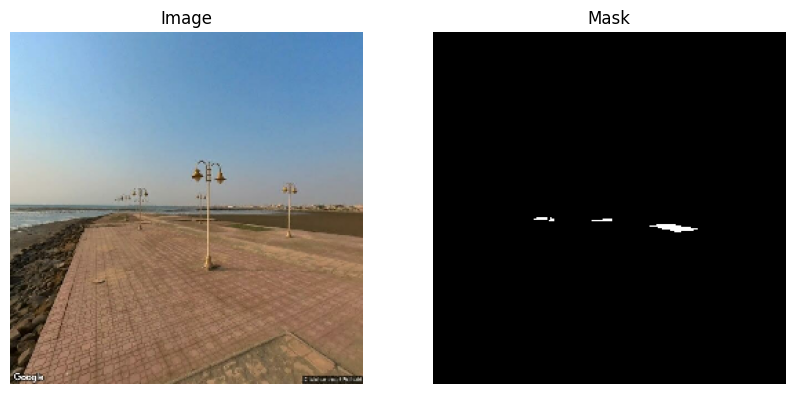

Sample 2:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


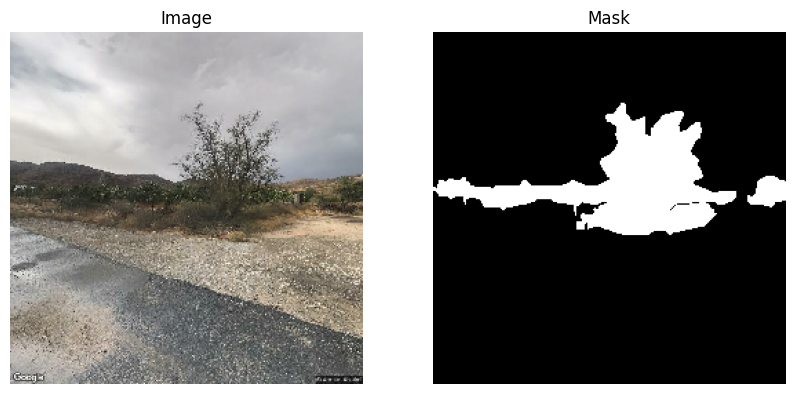

Sample 3:
Image shape: (256, 256, 3)
Mask unique values: [0]


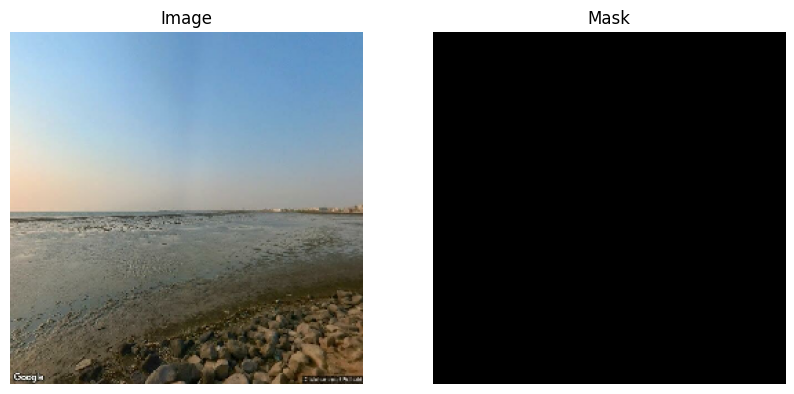

Sample 4:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


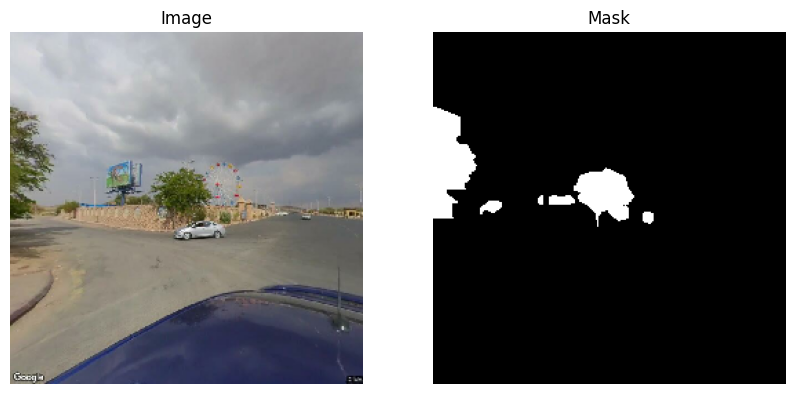

Sample 5:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


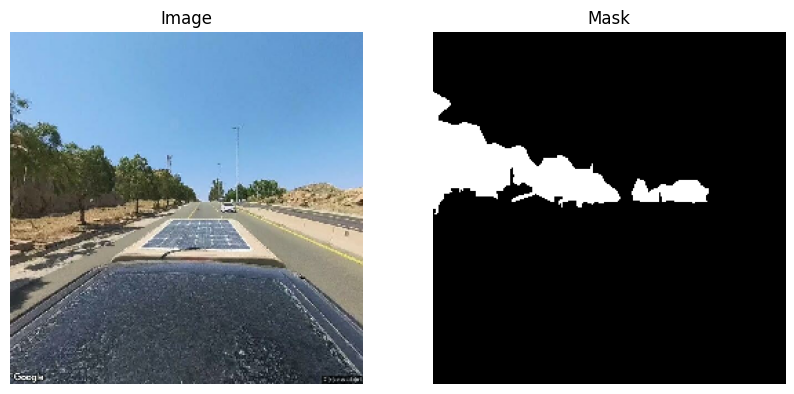

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# to visualize sample from the dataset
def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

def visual_dataset(dataset, num_samples=5):
    sample_images = []
    sample_masks = []
    for image, mask in dataset.take(num_samples):
        sample_images.append(image.numpy())
        sample_masks.append(mask.numpy())
    
    # Visualize the samples
    for i in range(num_samples):
        print(f"Sample {i + 1}:")
        print("Image shape:", sample_images[i].shape)
        print("Mask unique values:", np.unique(sample_masks[i]))
        visualize_sample(sample_images[i], sample_masks[i])

visual_dataset(train_ds)


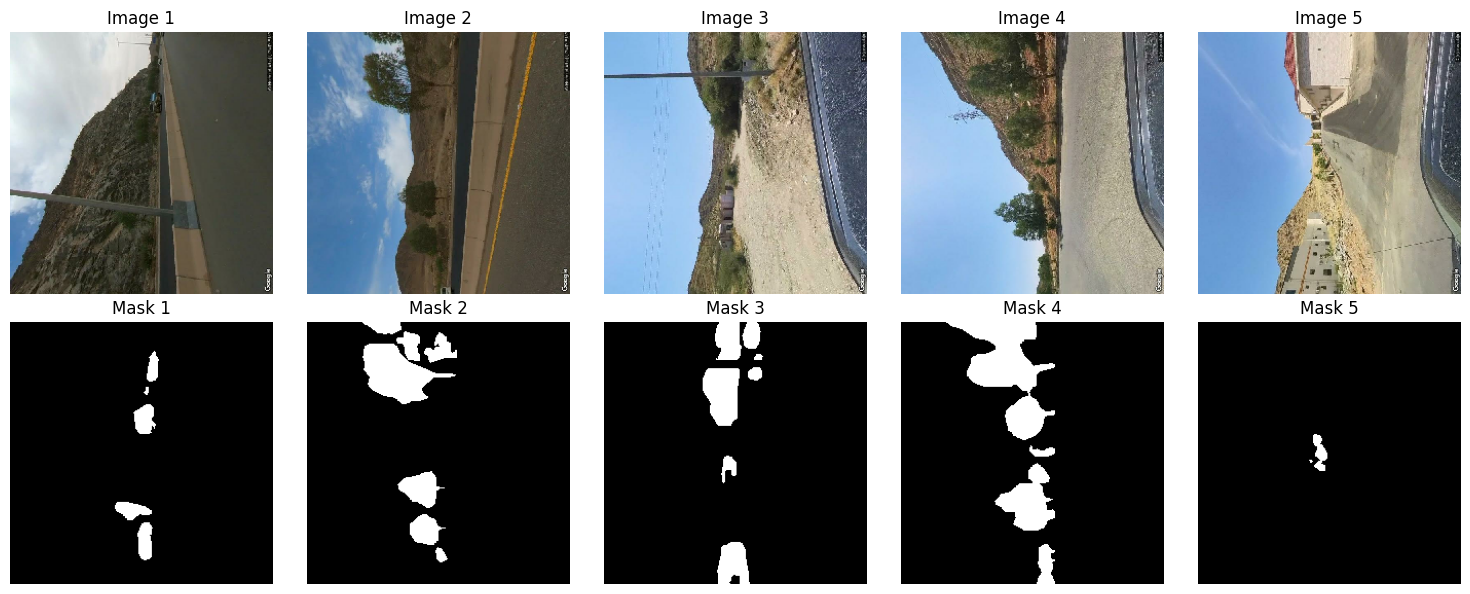

In [5]:
import matplotlib.pyplot as plt
# visualize for training 
def visualize_subset(train_dataset, num_samples=5):
    plt.figure(figsize=(15, 6))
    
    for i, (img_batch, mask_batch) in enumerate(train_dataset.take(1)):  # one batch
        for j in range(num_samples):
            
            img = img_batch[j].numpy()
            mask = mask_batch[j].numpy()

            plt.subplot(2, num_samples, j + 1)
            plt.title(f"Image {j + 1}")
            plt.imshow(img)  # Display the image
            plt.axis('off')
            
            plt.subplot(2, num_samples, num_samples + j + 1)
            plt.title(f"Mask {j + 1}")
            plt.imshow(mask.squeeze(), cmap='gray')  # Display the mask
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_subset(train_dataset, num_samples=5)

In [3]:
#for handling class imbalance
def extract_labels(dataset):
    all_masks = []
    for images, masks in dataset:
        all_masks.append(masks.numpy())  
    return np.concatenate(all_masks, axis=0).flatten()  


y_train = extract_labels(train_dataset)

class_labels = np.unique(y_train)

weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)

class_weight_dict = {i: weights[i] for i in range(len(weights))}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.5276826696543266, 1: 9.53092090184035}


In [4]:
#define metrices
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy


def dice_coef(y_true, y_pred, smooth=1):
    # Ensure both y_true and y_pred are float32
    y_true_f = K.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.cast(K.flatten(y_pred), tf.float32)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred > 0.5, [-1]), tf.float32)  # Apply thresholding here
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [5]:
from keras import layers, Model
from keras import regularizers
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Convolution block with increased L2 regularization
def convolution_block(block_input, num_filters=32, kernel_size=3, dilation_rate=1, use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same",
                      use_bias=use_bias, kernel_regularizer=regularizers.l2(0.1))(block_input)  
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)


    # Dilated Convolutions with different dilation rates
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)

    # Concatenating all the outputs
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6])
    output = convolution_block(x, kernel_size=1)
    return output 

def DeeplabV3Plus(image_size, num_classes):
    model_input = layers.Input(shape=(image_size, image_size, 3))
    preprocessed = tf.keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
    
    # Unfreeze some layers for fine-tuning
    for layer in resnet50.layers:
        layer.trainable = False  # Freeze all layers initially
    for layer in resnet50.layers[-150:]:  # Unfreeze the layers
        layer.trainable = True

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]), interpolation="bilinear")(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=64, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    # Adding more layers to the decoder part of DeeplabV3+
    x = convolution_block(x, num_filters=64)
    x = layers.Dropout(0.1)(x) 
    x = layers.UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation="bilinear")(x)
    
    model_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)
    return Model(inputs=model_input, outputs=model_output)

IMAGE_SIZE = 256  
NUM_CLASSES = 1   # For binary classification

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.75, patience=5, verbose=1, min_lr=1e-6)

model.compile(optimizer=AdamW(learning_rate=0.0001),
loss= dice_loss,
metrics=['accuracy', 'Precision', 'Recall', dice_coef,iou_metric]) 

history = model.fit(
    train_dataset,
    class_weight=class_weight_dict,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[
        lr_scheduler, 
        early_stopping ])

Epoch 1/50


I0000 00:00:1727802616.077348      98 service.cc:145] XLA service 0x7f3800003640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727802616.077417      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/388 ━━━━━━━━━━━━━━━━━━━━ 5:34:22 52s/step - Precision: 0.0783 - Recall: 0.5334 - accuracy: 0.4590 - dice_coef: 0.1383 - iou_metric: 0.0733 - loss: 36.9157

I0000 00:00:1727802638.741596      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 ━━━━━━━━━━━━━━━━━━━━ 129s 199ms/step - Precision: 0.1648 - Recall: 0.8279 - accuracy: 0.7515 - dice_coef: 0.1961 - iou_metric: 0.1680 - loss: 28.5803 - val_Precision: 0.0490 - val_Recall: 0.9996 - val_accuracy: 0.0568 - val_dice_coef: 0.0927 - val_iou_metric: 0.0492 - val_loss: 13.6172 - learning_rate: 1.0000e-04
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 73s 182ms/step - Precision: 0.5720 - Recall: 0.7841 - accuracy: 0.9557 - dice_coef: 0.5006 - iou_metric: 0.4729 - loss: 10.9054 - val_Precision: 0.0949 - val_Recall: 0.9674 - val_accuracy: 0.4995 - val_dice_coef: 0.1673 - val_iou_metric: 0.0953 - val_loss: 6.4393 - learning_rate: 1.0000e-04
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 72s 181ms/step - Precision: 0.6678 - Recall: 0.7565 - accuracy: 0.9670 - dice_coef: 0.6099 - iou_metric: 0.5322 - loss: 5.0466 - val_Precision: 0.1651 - val_Recall: 0.9130 - val_accuracy: 0.7561 - val_dice_coef: 0.2670 - val_iou_metric: 0.1628 - val_loss: 3.3103 - learning_rate: 1.0000e-04
Epoch 4/50
388

In [38]:
# Evaluate the model on the train dataset
train_loss, train_acc, val_dice_coef, precision_m, recall_m, iou_metric = model.evaluate(train_dataset)

print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'train Loss:':<20}{train_loss:>10.4f}")
print(f"{'train Accuracy:':<20}{train_acc:>10.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>10.4f}")
print(f"{'Precision:':<20}{precision_m:>10.4f}")
print(f"{'Recall:':<20}{recall_m:>10.4f}")
print(f"{'IoU Metric:':<20}{iou_metric:>10.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - Precision: 0.8614 - Recall: 0.8849 - accuracy: 0.9861 - dice_coef: 0.8553 - iou_metric: 0.7557 - loss: 0.1479
Metric                   Value
------------------------------
train Loss:             0.1478
train Accuracy:         0.9873
Dice Coefficient:       0.8744
Precision:              0.8888
Recall:                 0.8554
IoU Metric:             0.7570


In [37]:
# Evaluate the model on the val dataset
val_loss, val_acc, val_dice_coef, precision_m, recall_m, iou_metric = model.evaluate(val_dataset)

print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'val Loss:':<20}{val_loss:>10.4f}")
print(f"{'val Accuracy:':<20}{val_acc:>10.4f}")
print(f"{'Dice Coefficient:':<20}{val_dice_coef:>10.4f}")
print(f"{'Precision:':<20}{precision_m:>10.4f}")
print(f"{'Recall:':<20}{recall_m:>10.4f}")
print(f"{'IoU Metric:':<20}{iou_metric:>10.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - Precision: 0.8729 - Recall: 0.8618 - accuracy: 0.9870 - dice_coef: 0.8511 - iou_metric: 0.7505 - loss: 0.1521
Metric                   Value
------------------------------
val Loss:               0.1580
val Accuracy:           0.9852
Dice Coefficient:       0.8644
Precision:              0.8607
Recall:                 0.8460
IoU Metric:             0.7446


In [32]:
# Evaluate the model on the test dataset
test_loss, test_acc, test_dice_coef, precision_m, recall_m, iou_metric = model.evaluate(test_dataset)

print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'Test Loss:':<20}{test_loss:>10.4f}")
print(f"{'Test Accuracy:':<20}{test_acc:>10.4f}")
print(f"{'Dice Coefficient:':<20}{test_dice_coef:>10.4f}")
print(f"{'Precision:':<20}{precision_m:>10.4f}")
print(f"{'Recall:':<20}{recall_m:>10.4f}")
print(f"{'IoU Metric:':<20}{iou_metric:>10.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - Precision: 0.8798 - Recall: 0.8600 - accuracy: 0.9825 - dice_coef: 0.8538 - iou_metric: 0.7519 - loss: 0.1494
Metric                   Value
------------------------------
Test Loss:              0.1686
Test Accuracy:          0.9818
Dice Coefficient:       0.8584
Precision:              0.8575
Recall:                 0.8351
IoU Metric:             0.7274


In [33]:
# Evaluate on training dataset
train_loss, train_acc, train_dice_coef, train_precision, train_recall, train_iou = model.evaluate(train_dataset)

# Evaluate on validation dataset
val_loss, val_acc, val_dice_coef, val_precision, val_recall, val_iou = model.evaluate(val_dataset)

# Evaluate on test dataset
test_loss, test_acc, test_dice_coef, test_precision, test_recall, test_iou = model.evaluate(test_dataset)

print(f"{'Metric':<20}{'Train':>12}{'Validation':>12}{'Test':>12}")
print(f"{'-'*50}")
print(f"{'Loss:':<20}{train_loss:>12.4f}{val_loss:>12.4f}{test_loss:>12.4f}")
print(f"{'Accuracy:':<20}{train_acc:>12.4f}{val_acc:>12.4f}{test_acc:>12.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>12.4f}{val_dice_coef:>12.4f}{test_dice_coef:>12.4f}")
print(f"{'Precision:':<20}{train_precision:>12.4f}{val_precision:>12.4f}{test_precision:>12.4f}")
print(f"{'Recall:':<20}{train_recall:>12.4f}{val_recall:>12.4f}{test_recall:>12.4f}")
print(f"{'IoU Metric:':<20}{train_iou:>12.4f}{val_iou:>12.4f}{test_iou:>12.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - Precision: 0.8672 - Recall: 0.8840 - accuracy: 0.9864 - dice_coef: 0.8547 - iou_metric: 0.7564 - loss: 0.1485
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - Precision: 0.8807 - Recall: 0.8606 - accuracy: 0.9870 - dice_coef: 0.8634 - iou_metric: 0.7670 - loss: 0.1398
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - Precision: 0.8469 - Recall: 0.8620 - accuracy: 0.9839 - dice_coef: 0.8394 - iou_metric: 0.7323 - loss: 0.1638
Metric                     Train  Validation        Test
--------------------------------------------------
Loss:                     0.1472      0.1489      0.1685
Accuracy:                 0.9873      0.9846      0.9830
Dice Coefficient:         0.8744      0.8552      0.8486
Precision:                0.8877      0.8616      0.8584
Recall:                   0.8559      0.8548      0.8348
IoU Metric:               0.7589      0.7560      0.7278


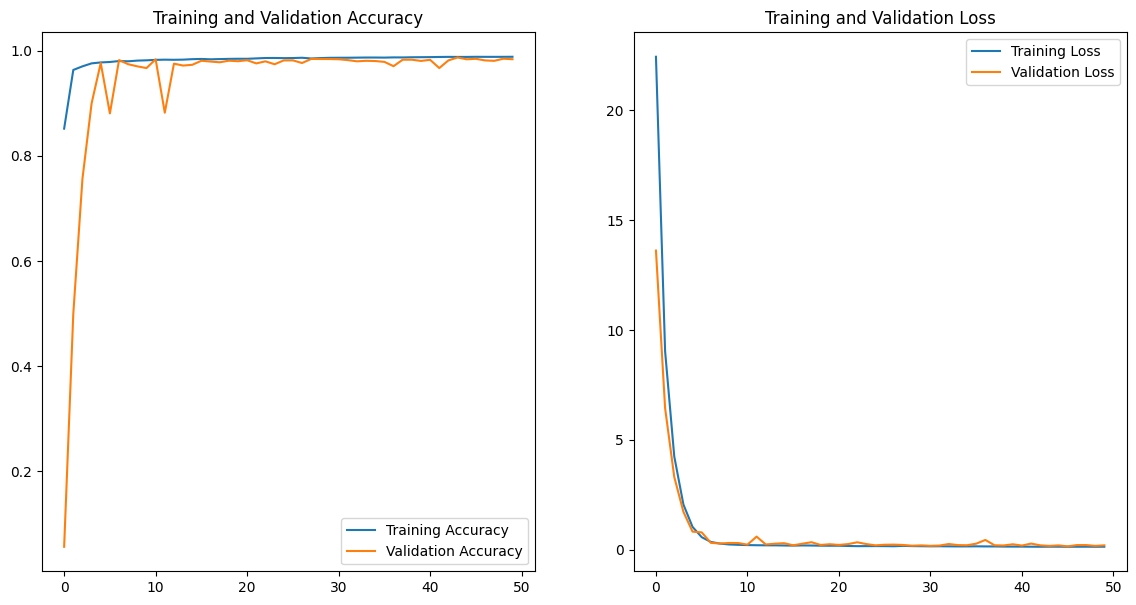

In [8]:
# Plot results
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_on_test(test_dataset, model):
    all_true_masks = []
    all_pred_masks = []

    # Iterate through the test dataset
    for images, true_masks in test_dataset:
        # Predict masks
        preds = model.predict(images)
        preds = tf.math.round(preds)  

        true_masks_np = tf.squeeze(true_masks).numpy().astype(np.uint8).flatten()
        preds_np = tf.squeeze(preds).numpy().astype(np.uint8).flatten()

        # Append to lists
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(preds_np)

    # Flatten the lists
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)

    # Generate classification report
    report = classification_report(all_true_masks, all_pred_masks, target_names=['Background', 'Foreground'])
    cm = confusion_matrix(all_true_masks, all_pred_masks)

    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

# Call the evaluation function
evaluate_model_on_test(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━

In [14]:
model.save('/kaggle/working/Fdeeplabv3+_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

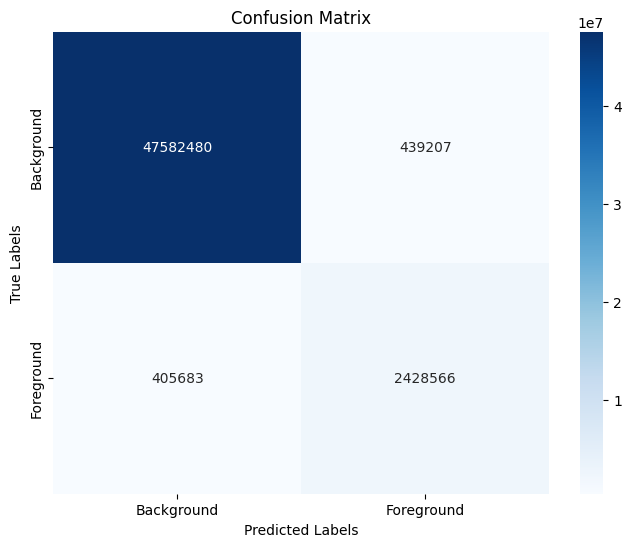

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_on_test(test_dataset, model):
    all_true_masks = []
    all_pred_masks = []

    # Iterate through the test dataset
    for images, true_masks in test_dataset:
        # Predict masks
        preds = model.predict(images)
        preds = tf.math.round(preds)  # Round predictions to binary (0 or 1)

        # Convert tensors to numpy arrays and flatten them
        true_masks_np = tf.squeeze(true_masks).numpy().astype(np.uint8).flatten()
        preds_np = tf.squeeze(preds).numpy().astype(np.uint8).flatten()

        # Append to lists
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(preds_np)

    # Flatten the lists
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)

    # Generate classification report
    report = classification_report(all_true_masks, all_pred_masks, target_names=['Background', 'Foreground'])
    cm = confusion_matrix(all_true_masks, all_pred_masks)

    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

evaluate_model_on_test(test_dataset, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


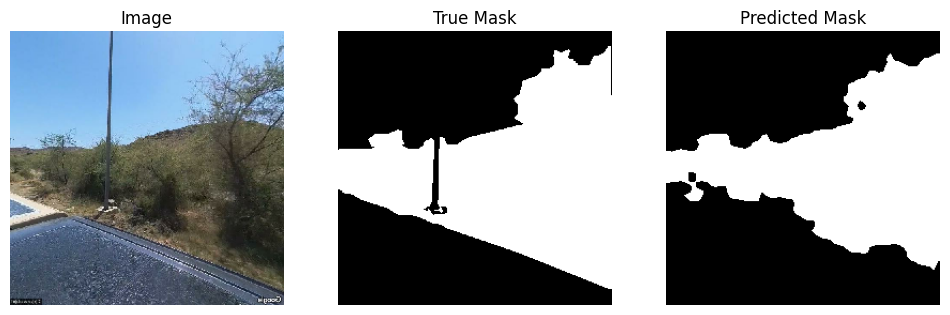

In [17]:
import numpy as np

def create_mask(pred_mask):

    pred_mask = np.squeeze(pred_mask)  
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  
    return pred_mask
import matplotlib.pyplot as plt

def display(images):
    plt.figure(figsize=(12, 6))
    
    titles = ['Image', 'True Mask', 'Predicted Mask']
    
    for i, img in enumerate(images):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        img_np = img.numpy() if hasattr(img, 'numpy') else img
        plt.imshow(np.squeeze(img_np), cmap='gray')  
        plt.axis('off')
    
    plt.show()
def show_predictions(dataset, num=1):

    for image, mask in dataset.take(num):
        image_np = image.numpy()
        mask_np = mask.numpy()
        
        pred_mask = model.predict(image_np)
        pred_mask_np = create_mask(pred_mask[0])
        
        display([image_np[0], mask_np[0], pred_mask_np])
show_predictions(train_dataset, num=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


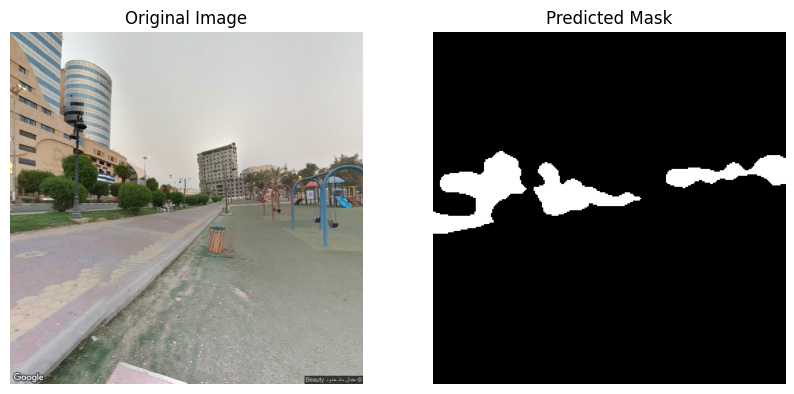

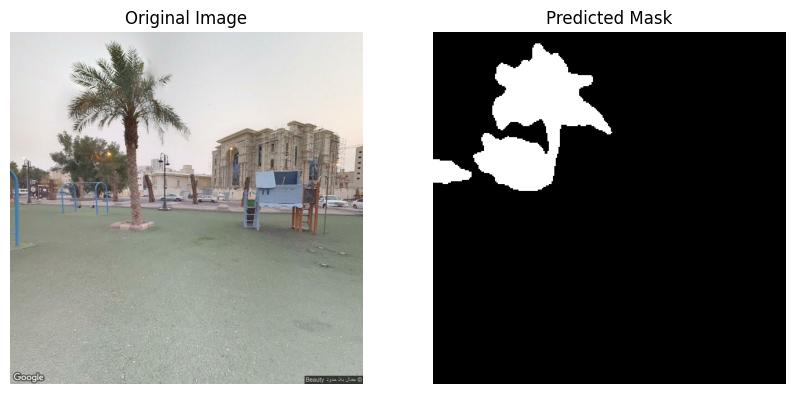

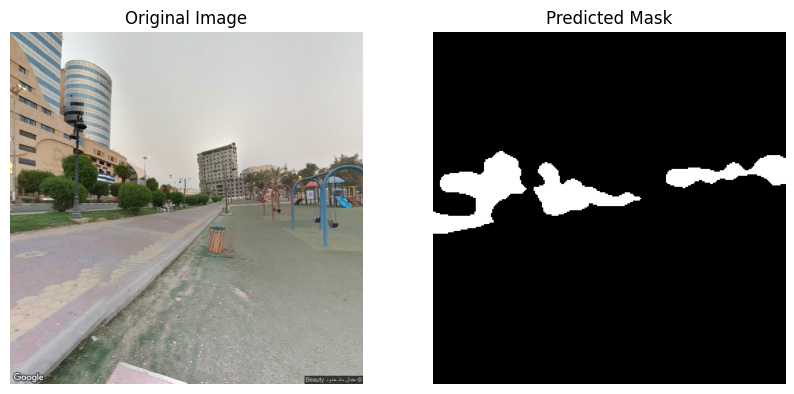

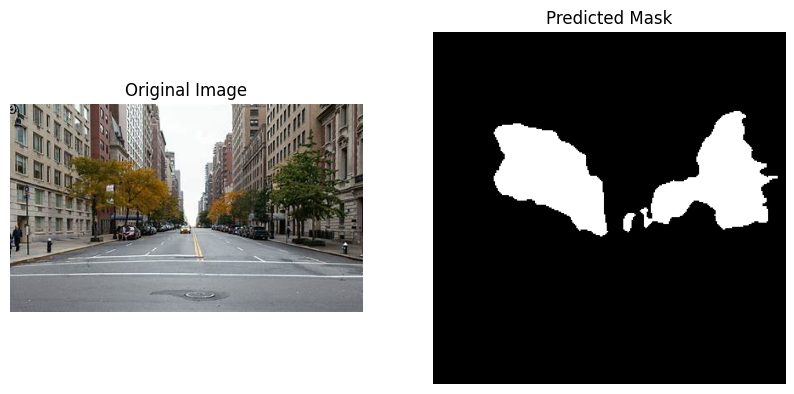

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.convert_image_dtype(img, tf.float32)  
    img = tf.image.resize(img, (256, 256)) 
    img = tf.expand_dims(img, axis=0) 
    return img

def predict_image(model, image_path):
    img = load_and_preprocess_image(image_path)

    predictions = model.predict(img)

    pred_binary = (predictions > 0.5).astype(np.uint8) 
    
    return pred_binary

def display_results(original_img_path, pred_mask):
    original_img = tf.io.read_file(original_img_path)
    original_img = tf.image.decode_png(original_img, channels=3)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img.numpy())
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask[0, :, :, 0], cmap='gray')  
    plt.axis("off")

    plt.show()

image_path = '/kaggle/input/teestt/image_21.409337870102185_39.79935897358726_90_2020-10.jpg' 
image_path1 = '/kaggle/input/teestt/image_21.409337870102185_39.79935897358726_180_2020-10.jpg'  
image_path2 = '/kaggle/input/teestt/image_21.409337870102185_39.79935897358726_90_2020-10.jpg'  
image_path3 = '/kaggle/input/ttt1111/download (1).jpg'  

predicted_mask = predict_image(model, image_path)
predicted_mask1 = predict_image(model, image_path1)
predicted_mask2 = predict_image(model, image_path2)
predicted_mask3 = predict_image(model, image_path3)

display_results(image_path, predicted_mask)
display_results(image_path1, predicted_mask1)
display_results(image_path2, predicted_mask2)
display_results(image_path3, predicted_mask3)